##### 5: Soil Carbon Dioxide (CO2)

Soil CO2 concentration is a key metric in ecological studies, providing insights into crucial aspects of the carbon cycle within terrestrial ecosystems. The NEON Soil CO2 dataset offers measurements of CO2 concentration in soil air at different depths below the soil surface, commencing at approximately 2 cm. These measurements, presented as 1-minute and 30-minute averages, are derived from all five Instrumented Soil Plots per site.

Understanding soil CO2 concentrations is essential for estimating soil CO2 efflux rates, particularly when combined with other NEON data products. Soil CO2 efflux represents a significant exchange of carbon between terrestrial ecosystems and the atmosphere, making it a critical component of the carbon cycle. Moreover, since the majority of soil CO2 originates from microbial, root, and soil faunal respiration, soil CO2 efflux serves as a valuable indicator of total soil biological activity.

Within each soil plot, CO2 sensors are strategically positioned at multiple depths, typically within 1 meter of each other, allowing for the characterization of vertical CO2 gradients within the soil profile. Measurements are taken at three depths within each plot, starting at approximately 2 cm below the soil surface.

Throughout this section, we will guide you through the process of accessing and analyzing NEON Soil CO2 data using the Jupyter environment. By leveraging effective data retrieval, preprocessing, visualization, and analysis techniques, you will gain the necessary skills to interpret soil CO2 dynamics and explore their ecological implications.

In [1]:
# Reading the Downloaded and unzipped files
import os
os.listdir('/Volumes/Thomas/Tutorials/NEON/Data/filesToStack00095/stackedFiles/')

['citation_00095_RELEASE-2024.txt',
 'readme_00095.txt',
 'variables_00095.csv',
 'SCO2C_30_minute.csv',
 'sensor_positions_00095.csv',
 'issueLog_00095.csv']

In [2]:
import pandas as pd
# The 1 minute data is very large and when reading it make sure your processing power can handle it
SCO2C_30_Minute = pd.read_csv('/Volumes/Thomas/Tutorials/NEON/Data/filesToStack00095/stackedFiles/SCO2C_30_minute.csv')
SCO2C_30_Minute['startDateTime'] = pd.to_datetime(SCO2C_30_Minute['startDateTime'])
SCO2C_30_Minute.set_index('startDateTime', inplace=True)
SCO2C_30_Minute.columns

Index(['domainID', 'siteID', 'horizontalPosition', 'verticalPosition',
       'endDateTime', 'soilCO2concentrationMean',
       'soilCO2concentrationMinimum', 'soilCO2concentrationMaximum',
       'soilCO2concentrationVariance', 'soilCO2concentrationNumPts',
       'soilCO2concentrationExpUncert', 'soilCO2concentrationStdErMean',
       'finalQF', 'publicationDate', 'release'],
      dtype='object')

In [3]:
columns_of_interest = ['siteID', 'horizontalPosition', 'verticalPosition',
                       'soilCO2concentrationMean', 'soilCO2concentrationMinimum',
                       'soilCO2concentrationMaximum','finalQF']
sc02_df = SCO2C_30_Minute[columns_of_interest]
df_c02 = sc02_df[(sc02_df['finalQF'] == 0)]
# Group by date and verticalPosition, then aggregate using mean for mean_cols and first for first_cols
daily_c02 = df_c02.groupby([df_c02.index.date,
                            'verticalPosition']).agg({'siteID': 'first','siteID': 'first',
                                                      'soilCO2concentrationMean': 'mean',
                                                      'soilCO2concentrationMinimum': 'mean',
                                                      'soilCO2concentrationMaximum': 'mean'})
# Reset index to make date and verticalPosition regular columns
daily_c02.reset_index(inplace=True)
# Rename level_0 to Date
daily_c02.rename(columns={'level_0': 'Date'}, inplace=True)

# Set Date column as index
daily_c02.set_index('Date', inplace=True)

In [4]:
sensorp = pd.read_csv('filesToStack00095/stackedFiles/sensor_positions_00095.csv')
# Selecting subset of data
#s_plot_1 = sensorp[sensorp['HOR.VER'].astype(str).str.startswith('1.50')]
coi = ['siteID', 'HOR.VER', 'xOffset', 'positionEndDateTime', 'yOffset', 'zOffset']
sensor_l = sensorp[coi].copy()  # Ensure to make a copy
# Convert the column to string type
sensor_l['HOR.VER'] = sensor_l['HOR.VER'].astype(str)
# Splitting the column and creating two new columns
sensor_l[['horizontalPosition',
          'verticalPosition']] = sensor_l['HOR.VER'].str.split('.', expand=True)

# Convert the values back to numeric
sensor_l['horizontalPosition'] = pd.to_numeric(sensor_l['horizontalPosition'])
sensor_l['verticalPosition'] = pd.to_numeric(sensor_l['verticalPosition'])

# Dropping the original column
sensor_l.drop(columns=['HOR.VER'], inplace=True)
sensor_l.dropna(inplace=True)

In [5]:
# Creating a new DataFrame to store the result
plot_c02 = daily_c02.copy()

# Creating a dictionary to map sensor depth values based on horizontal and vertical positions
s_depth = {(row['verticalPosition']): row['zOffset'] 
                    for _, row in sensor_l.iterrows()}

# Function to populate soilDepth column
def p_sensor_depth(row, sensor_depth):
    vertical_pos = row['verticalPosition']
    sensor_depth_value = s_depth.get(vertical_pos)
    return sensor_depth_value
plot_c02['z0ffset'] = plot_c02.apply(lambda row: p_sensor_depth(row, s_depth), axis=1)

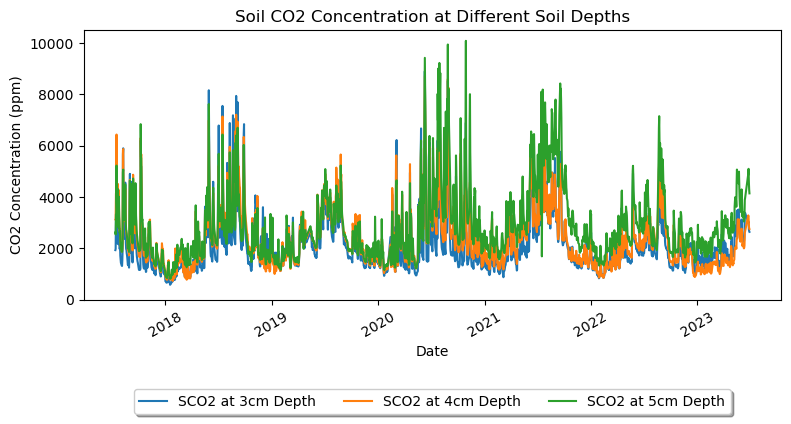

In [11]:
import matplotlib.pyplot as plt
# Filter data for each soil depth
depth_3cm = plot_c02[(plot_c02['verticalPosition'] == 501)]
depth_4cm = plot_c02[(plot_c02['verticalPosition'] == 502)]
depth_5cm = plot_c02[(plot_c02['verticalPosition'] == 503)]
# Plotting
plt.figure(figsize=(9, 3.5))
plt.plot(depth_3cm.index, depth_3cm['soilCO2concentrationMean'], label='SCO2 at 3cm Depth')
plt.plot(depth_4cm.index, depth_4cm['soilCO2concentrationMean'], label='SCO2 at 4cm Depth')
plt.plot(depth_5cm.index, depth_5cm['soilCO2concentrationMean'], label='SCO2 at 5cm Depth')

# Set y-axis limits
plt.ylim(0, 10500)

# Adding labels and legend
plt.xlabel('Date')
plt.xticks(rotation=30)
plt.ylabel('CO2 Concentration (ppm)')
plt.title('Soil CO2 Concentration at Different Soil Depths')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), shadow=True, ncol=3)


# Display the plot
plt.show()

In [17]:
# Group by date and vertical position, and aggregate by taking the mean over horizontal position
data_plots = plot_c02.groupby([plot_c02.index, 'verticalPosition']).agg({
    'soilCO2concentrationMean': 'mean',
    'soilCO2concentrationMinimum': 'mean',
    'soilCO2concentrationMaximum': 'mean',
    'z0ffset': 'first'
})

# Reset index to make 'verticalPosition' and 'Date' regular columns
data_plots.reset_index(inplace=True)

columns = ['Date', 'soilCO2concentrationMean', 'z0ffset']
df_1 = data_plots[columns]
df_1.to_csv('TALL_daily_SoilCO2concentration.csv')
df_1.head()

,Date,soilCO2concentrationMean,z0ffset
0,2017-07-13,1930.344792,-0.06
1,2017-07-13,3123.135667,-0.04
2,2017-07-13,2617.242875,-0.07
3,2017-07-14,1982.122083,-0.06
4,2017-07-14,3150.291167,-0.04
